Plots Generated by randomized_priors.ipynb from Kevin Murphy [1]

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn

# Generate dataset and grid
torch.manual_seed(0)  # Set a seed for reproducibility
X = torch.rand(100, 1) * 0.5
x_grid = torch.linspace(-5, 5, 1000).reshape(-1, 1)

# Define function
def target_toy(x):
    torch.manual_seed(0)  # Reset seed for consistent randomness
    epsilons = torch.randn(3) * 0.02
    return (
        x + 0.3 * torch.sin(2 * torch.pi * (x + epsilons[0])) +
        0.3 * torch.sin(4 * torch.pi * (x + epsilons[1])) + epsilons[2]
    )

# Generate target values
torch.manual_seed(0)  # Reset seed for consistent randomness
Y = torch.stack([target_toy(x) for x in X])


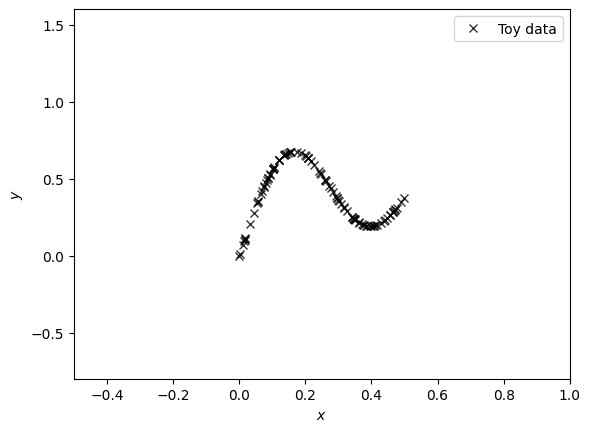

In [2]:
# Plot the generated data
plt.figure()  # figsize=[12,6], dpi=200)
plt.plot(X, Y, "kx", label="Toy data", alpha=0.8)
# plt.title('Simple 1D example with toy data by Blundell et. al (2015)')
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.xlim(-0.5, 1.0)
plt.ylim(-0.8, 1.6)
plt.legend()
plt.show()

In [3]:
class GenericNet(nn.Module):
    def __init__(self, input_dim):
        super(GenericNet, self).__init__()
        self.input_dim = input_dim
        
        self.net = nn.Sequential(
            nn.Linear(in_features=input_dim, out_features=16),
            nn.ELU(),
            nn.Linear(in_features=16, out_features=16),
            nn.ELU(),
            nn.Linear(in_features=16, out_features=1)
        )
        # Additional layers can be added here based on the architecture
        # Apply Xavier uniform initialization to the weights
        self.init_weights(self.net)

    def forward(self, x):
        return self.net(x)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)


class Model(nn.Module):
    def __init__(self, beta):
        super(Model, self).__init__()
        self.prior = GenericNet(input_dim=1)  # Specify the input dimension
        self.trainable = GenericNet(input_dim=1)  # Specify the input dimension
        self.beta = beta

    def forward(self, x):
        x1 = self.prior(x)
        x2 = self.trainable(x)
        return self.beta * x1 + x2



In [4]:
# Function to create train state with key initialization
def create_train_optim(model, lr):
    model.train()  # Set the model in training mode
    optimizer = optim.Adam(model.trainable.parameters(), lr=lr)
    return optimizer

# Training function
def train(model, optimizer, epochs, X, Y):
    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(X)
        loss = torch.mean((output - Y)**2)
        loss.backward()
        optimizer.step()
    return model

# Prediction function
def get_predictions(model, X):
    model.eval()
    with torch.no_grad():
        Y_prior = model.prior(X)
        Y_trainable = model.trainable(X)
        Y_model = model(X)
    return Y_prior, Y_trainable, Y_model

    
# Create model and optimizer
beta = 3
lr = 0.03
epochs = 2000
# Set a random seed for reproducibility
seed = 2

# Create model and optimizer
torch.manual_seed(seed)
model = Model(beta=beta)
optimizer = create_train_optim(model, lr=lr)

# Train the model
model = train(model, optimizer, epochs=epochs, X=X, Y=Y)

# Get predictions
# predictions = get_predictions(model, beta=3, X=X)
Y_prior, Y_trainable, Y_model = get_predictions(model, x_grid)

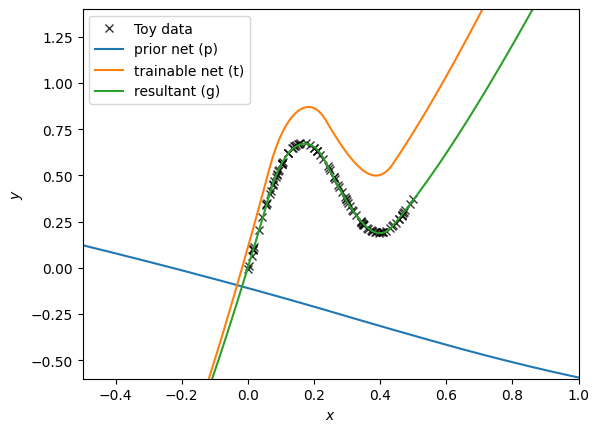

In [5]:
# Plot the results
plt.figure()  # figsize=[12,6], dpi=200)
plt.plot(X, Y, "kx", label="Toy data", alpha=0.8)
plt.plot(x_grid, 3 * Y_prior, label="prior net (p)")
plt.plot(x_grid, Y_trainable, label="trainable net (t)")
plt.plot(x_grid, Y_model, label="resultant (g)")
# plt.title('Predictions of the prior network: random function')
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.xlim(-0.5, 1.0)
plt.ylim(-0.6, 1.4)
plt.legend()

# plt.savefig("randomized_priors_single_model.pdf")
# plt.savefig("randomized_priors_single_model.png")

plt.show()

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Generate bootstrap of given size
def generate_bootstrap(seed, size):
    torch.manual_seed(seed)  # Fix random seed for reproducibility
    return torch.randint(0, size, (size,), generator=torch.manual_seed(seed))

# An ensemble model with randomized prior nets
def build_ensemble(n_estimators, beta, lr, epochs, X, Y, bootstrap):
    train_keys = torch.randint(0, int(1e9), (n_estimators,), dtype=torch.int64).tolist()
    if bootstrap:
        bootstraps = torch.stack([generate_bootstrap(42 * i, X.shape[0]) for i in range(1, n_estimators + 1)])
        bootstraps_flat = bootstraps.view(-1)  # Flatten the matrix
        X_b = torch.index_select(X, 0, bootstraps_flat)
        Y_b = torch.index_select(Y, 0, bootstraps_flat)
    else:
        X_b = X.repeat(n_estimators, 1, 1)
        Y_b = Y.repeat(n_estimators, 1, 1)

    ensemble_train = []
    
    for i, train_key in enumerate(train_keys):
        key, _ = torch.manual_seed(train_key), torch.manual_seed(train_key)  # Fix random seed for reproducibility
        model = Model(beta=beta)
        model.apply(model.prior.init_weights)
        model.apply(model.trainable.init_weights)

        optimizer = create_train_optim(model, lr=lr)
        trained_model = train(model, optimizer, epochs, X_b[i], Y_b[i])
        ensemble_train.append(trained_model)
    
    return ensemble_train

# Array of predictions for each model in trained ensemble
def get_ensemble_predictions(n_estimators, beta, lr, epochs, X, Y, X_new, bootstrap=False):
    ensemble = build_ensemble(n_estimators, beta, lr, epochs, X, Y, bootstrap)
    
    result = []
    for model in ensemble:
        predictions = get_predictions(model, X_new)
        result.append(predictions)
    
    return result



In [7]:
# Compute prediction values for each net in ensemble
n_estimators = 9
beta = 3
learning_rate = 0.03
epochs = 2000

result = get_ensemble_predictions(n_estimators, beta, learning_rate, epochs, X, Y, x_grid)


In [8]:
# Initialize empty lists to store the assigned values
p_grid = []
t_grid = []
y_grid = []

# Iterate through each sublist in the results
for sublist in result:
    # Assign x_grid to the first list in the sublist
    p_grid.append(sublist[0])
    
    # Assign t_grid to the second list in the sublist
    t_grid.append(sublist[1])
    
    # Assign y_grid to the third list in the sublist
    y_grid.append(sublist[2])



<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 2400x2400 with 0 Axes>

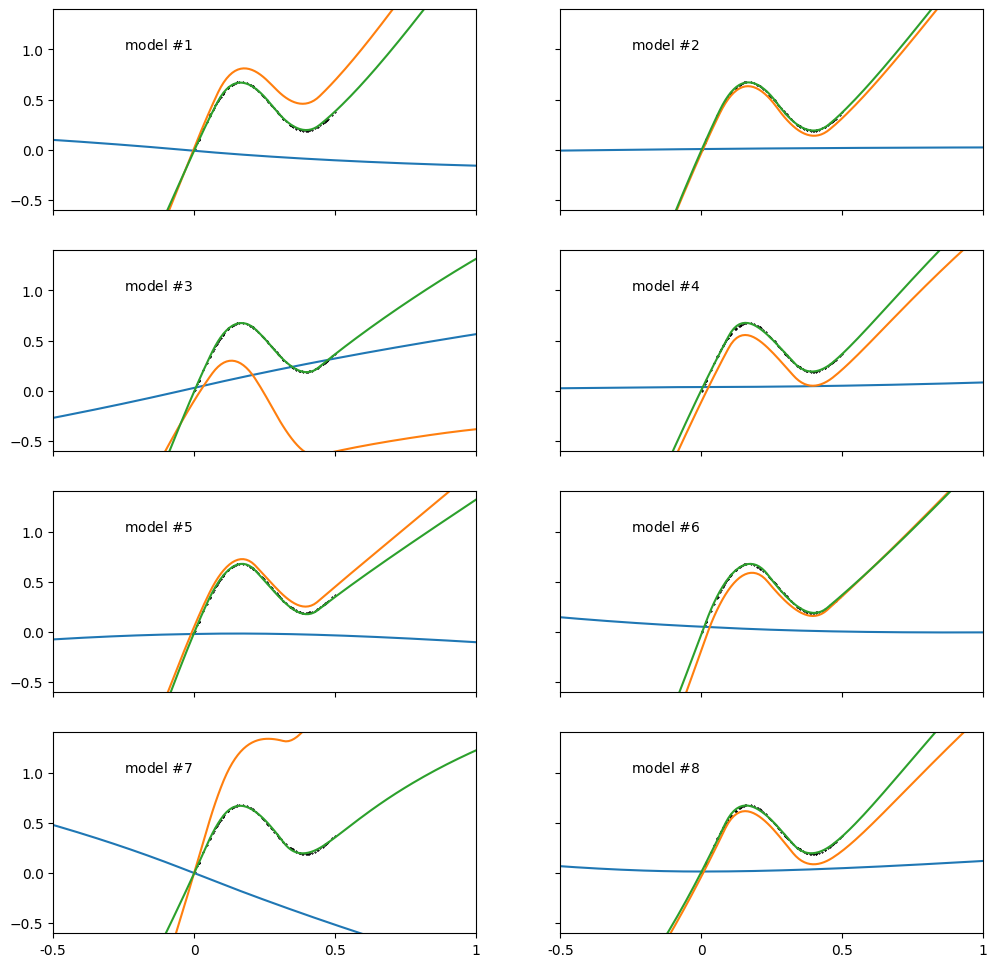

In [9]:
# Plot the results
plt.figure(figsize=[12, 12], dpi=200)
fig, axs = plt.subplots(nrows=4, ncols=2, sharex=True, sharey=True, figsize=[12, 12])
# axs = axs.flatten()


for i in range(8):
    if i % 2 == 0:
        k = i // 2
        j = 0
    else:
        k = i // 2
        j = 1
    # pl.subplot(4, 2,i+1)
    axs[k, j].text(-0.25, 1, f"model " + r"$\#$" + f"{i+1}")
    if k == 3:
        #         at = jnp.array([-0.5,0,0.5,1])
        #         labels= [f"{label:.0f}" for label in at]
        #         axs[k,j].set_xlim(0.5,1)
        #         axs[k,j].set_xticks(at)
        axs[k, j].set_xticklabels([-0.5, 0, 0.5, 1])
        axs[k, j].set_xlim([-0.5, 1])
    else:
        # axs[k,j].set_xlim(0.5,1)
        axs[k, j].set_xticks([-0.5, 0, 0.5, 1])
        axs[k, j].set_xlim([-0.5, 1])
    axs[k, j].set_ylim(-0.6, 1.4)
    axs[k, j].plot(X, Y, "kx", label="Toy data", alpha=0.8, markersize=1)
    axs[k, j].plot(x_grid, p_grid[i].squeeze(), label="prior net (p)")
    axs[k, j].plot(x_grid, t_grid[i].squeeze(), label="trainable net (t)")
    axs[k, j].plot(x_grid, y_grid[i].squeeze(), label="resultant (g)")
    # axs[k, j].plot(x_grid, p_grid[i, :, 0], label="prior net (p)")
    # axs[k, j].plot(x_grid, t_grid[i, :, 0], label="trainable net (t)")
    # axs[k, j].plot(x_grid, y_grid[i, :, 0], label="resultant (g)")
    # ax.set_title("Ensemble: Model \#{}".format(i + 1))
    # plt.xlabel('$x$'); plt.ylabel('$y$')

    # plt.axis('off')
    # plt.xticks([])
    # plt.yticks([])
    # ax.legend(frameon = False)
    # sns.despine()
# if is_latexify_enabled():
#     plt.subplots_adjust(wspace=3)
# plt.tight_layout()
# pml.savefig("randomized_priors_multi_model")
# plt.savefig("randomized_priors_multi_model.png")
plt.show

In [10]:
betas = [0.001, 5, 50, 100]


# Compute prediction values for each net in ensemble
n_estimators = 9
beta = 3
learning_rate = 0.03
epochs = 3000


results = []
for beta in betas:
    result = get_ensemble_predictions(n_estimators, beta, learning_rate, epochs, X, Y, x_grid)
    # Initialize empty lists to store the assigned values
    y_grid = []
    # Iterate through each sublist in the results
    for sublist in result:
        # Assign y_grid to the third list in the sublist
        y_grid.append(sublist[2])
    results.append(y_grid)




In [11]:
means = []
stds = []

for result in results:
    stacked_data = torch.stack(result, dim=0)
    # Calculate mean and standard deviation along the first dimension
    means.append(torch.mean(stacked_data, dim=0))
    stds.append(torch.std(stacked_data, dim=0))


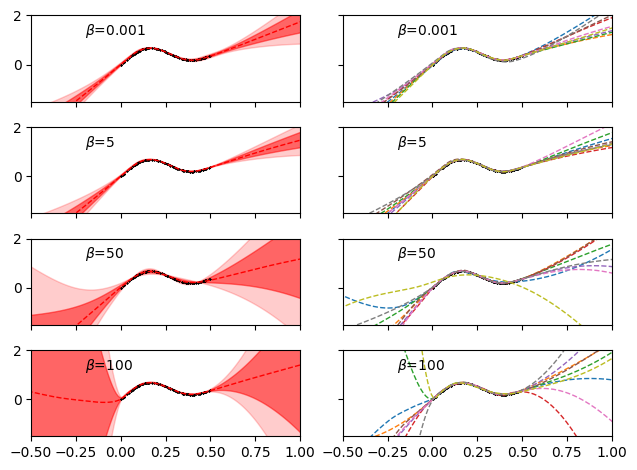

In [12]:
# Plot mean and std for each beta
# fig = plt.figure(figsize=[8, len(betas) * 3], dpi=150)
fig, axs = plt.subplots(nrows=4, ncols=2, sharex=True, sharey=True)
for i, beta in enumerate(betas):
    # Plot predictive mean and std (left graph)
    # plt.subplot(len(betas), 2, 2 * i + 1)
    axs[i, 0].plot(X, Y, "kx", label="Toy data", markersize=1)
    # plt.title(f'Mean and Deviation for beta={beta}', fontsize=12)
    if beta < 1:
        axs[i, 0].text(-0.2, 1.2, r"$\beta$" + f"={beta:.3f}")
        # axs[i,0].set_title(f"beta={beta:.3f}")
    else:
        axs[i, 0].text(-0.2, 1.2, r"$\beta$=" + f"{int(beta)}")
        # axs[i,0].set_title(f"beta={int(beta)}")
    axs[i, 0].set_xlim(-0.5, 1)
    axs[i, 0].set_ylim(-2, 2)
    # plt.legend()
    axs[i, 0].plot(x_grid, means[i], "r--", linewidth=1)
    axs[i, 0].fill_between(x_grid.reshape(1, -1)[0], (means[i] - stds[i]).squeeze(), (means[i] + stds[i]).squeeze(), alpha=0.5, color="red")
    axs[i, 0].fill_between(
        x_grid.reshape(1, -1)[0], (means[i] + 2 * stds[i]).squeeze(), (means[i] - 2 * stds[i]).squeeze(), alpha=0.2, color="red"
    )

    # Plot means of each net in ensemble (right graph)
    # plt.subplot(len(betas), 2, 2 * i + 2)
    axs[i, 1].plot(X, Y, "kx", label="Toy data", markersize=1)
    # plt.title(f'Samples for beta={beta}', fontsize=12)
    if beta < 1:
        axs[i, 1].text(-0.2, 1.2, r"$\beta$" + f"={beta:.3f}")
        # axs[i,1].set_title(f"beta={beta:.3f}")
    else:
        axs[i, 1].text(-0.2, 1.2, r"$\beta$=" + f"{int(beta)}")
        # axs[i,1].set_title(f"beta={int(beta)}")

    # if is_latexify_enabled():
    #     axs[i, 1].set_xticklabels([-0.5, 0, 0.5, 1])
    axs[i, 1].set_xlim(-0.5, 1)
    axs[i, 1].set_ylim(-1.5, 2)
    # sns.despine()
    # plt.legend()
    for j in range(n_estimators):
        axs[i, 1].plot(x_grid, results[i][j].squeeze(), linestyle="--", linewidth=1)
        # axs[i, 1].plot(x_grid, preds[2][i][j, :, 0], linestyle="--", linewidth=1)


plt.tight_layout()
# if is_latexify_enabled():
#     plt.subplots_adjust(wspace=5.5)
# pml.savefig("randomized_priors_changing_beta")
# plt.savefig("randomized_priors_changing_beta.png")
plt.show()

In [13]:
n, beta, lr, epochs = 9, 50, 0.03, 3000

# With prior, with bootstrap (original)
results_1 = get_ensemble_predictions(n, beta, lr, epochs, X, Y, x_grid)
y_grid_1 = []
# Iterate through each sublist in the results
for sublist in results_1:
    # Assign y_grid to the third list in the sublist
    y_grid_1.append(sublist[2])

means_1 = torch.mean(torch.stack(y_grid_1, dim=0), dim=0)
stds_1 = torch.std(torch.stack(y_grid_1, dim=0), dim=0)
# # With prior, without bootstrap
# *_, y_grid_2 = get_ensemble_predictions(n, beta, lr, epochs, X, Y, x_grid, False)
results_2 = get_ensemble_predictions(n, beta, lr, epochs, X, Y, x_grid, False)
y_grid_2 = []
# Iterate through each sublist in the results
for sublist in results_2:
    # Assign y_grid to the third list in the sublist
    y_grid_2.append(sublist[2])

means_2 = torch.mean(torch.stack(y_grid_2, dim=0), dim=0)
stds_2 = torch.std(torch.stack(y_grid_2, dim=0), dim=0)

# # Without prior, with bootstrap
results_3 = get_ensemble_predictions(n, 0, lr, epochs, X, Y, x_grid)
y_grid_3 = []
# Iterate through each sublist in the results
for sublist in results_3:
    # Assign y_grid to the third list in the sublist
    y_grid_3.append(sublist[2])

means_3 = torch.mean(torch.stack(y_grid_3, dim=0), dim=0)
stds_3 = torch.std(torch.stack(y_grid_3, dim=0), dim=0)
# # Without prior, without bootstrap
results_4 = get_ensemble_predictions(n, 0, lr, epochs, X, Y, x_grid, False)
y_grid_4 = []
# Iterate through each sublist in the results
for sublist in results_4:
    # Assign y_grid to the third list in the sublist
    y_grid_4.append(sublist[2])

means_4 = torch.mean(torch.stack(y_grid_4, dim=0), dim=0)
stds_4 = torch.std(torch.stack(y_grid_4, dim=0), dim=0)

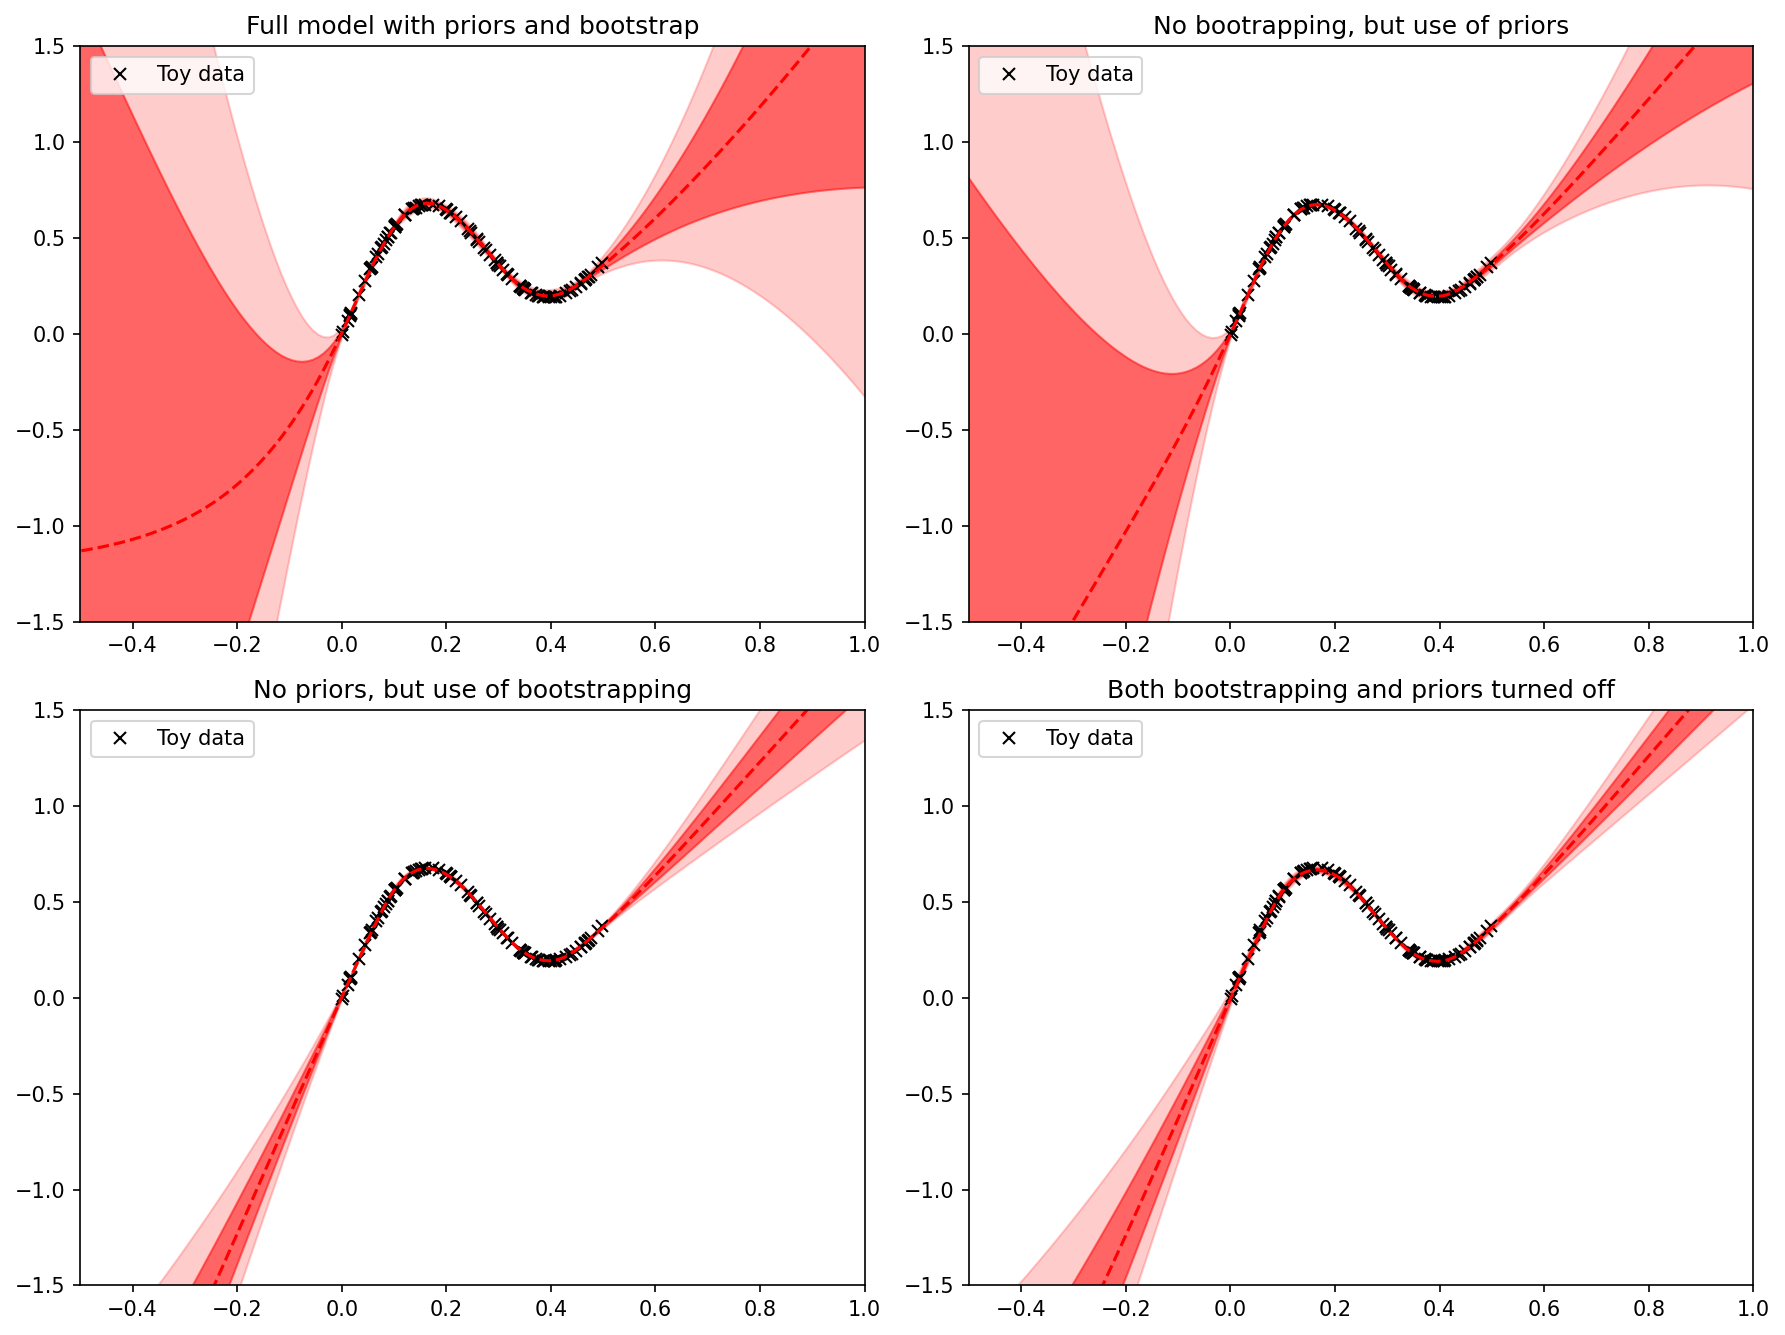

In [14]:
# Plot the four types of models
fig = plt.figure(figsize=[12, 9], dpi=150)
# fig.suptitle('Bootstrapping and priors: impact of model components on result',
#             verticalalignment='center')

# With prior, with bootstrap
plt.subplot(2, 2, 1)
plt.plot(X, Y, "kx", label="Toy data")
plt.title("Full model with priors and bootstrap", fontsize=12)
plt.xlim(-0.5, 1.0)
plt.ylim(-1.5, 1.5)
plt.legend()
plt.plot(x_grid, means_1, "r--", linewidth=1.5)
plt.fill_between(x_grid.reshape(1, -1)[0], (means_1 - stds_1).squeeze(), (means_1 + stds_1).squeeze(), alpha=0.5, color="red")
plt.fill_between(x_grid.reshape(1, -1)[0], (means_1 + 2 * stds_1).squeeze(), (means_1 - 2 * stds_1).squeeze(), alpha=0.2, color="red")

# With prior, without bootstrap
plt.subplot(2, 2, 2)
plt.plot(X, Y, "kx", label="Toy data")
plt.title("No bootrapping, but use of priors", fontsize=12)
plt.xlim(-0.5, 1.0)
plt.ylim(-1.5, 1.5)
plt.legend()
plt.plot(x_grid, means_2, "r--", linewidth=1.5)
plt.fill_between(x_grid.reshape(1, -1)[0], (means_2 - stds_2).squeeze(), (means_2 + stds_2).squeeze(), alpha=0.5, color="red")
plt.fill_between(x_grid.reshape(1, -1)[0], (means_2 + 2 * stds_2).squeeze(), (means_2 - 2 * stds_2).squeeze(), alpha=0.2, color="red")

# Without prior, with bootstrap
plt.subplot(2, 2, 3)
plt.plot(X, Y, "kx", label="Toy data")
plt.title("No priors, but use of bootstrapping", fontsize=12)
plt.xlim(-0.5, 1.0)
plt.ylim(-1.5, 1.5)
plt.legend()
plt.plot(x_grid, means_3, "r--", linewidth=1.5)
plt.fill_between(x_grid.reshape(1, -1)[0], (means_3 - stds_3).squeeze(), (means_3 + stds_3).squeeze(), alpha=0.5, color="red")
plt.fill_between(x_grid.reshape(1, -1)[0], (means_3 + 2 * stds_3).squeeze(), (means_3 - 2 * stds_3).squeeze(), alpha=0.2, color="red")

# Without prior, without bootstrap
plt.subplot(2, 2, 4)
plt.plot(X, Y, "kx", label="Toy data")
plt.title("Both bootstrapping and priors turned off", fontsize=12)
plt.xlim(-0.5, 1.0)
plt.ylim(-1.5, 1.5)
plt.legend()
plt.plot(x_grid, means_4, "r--", linewidth=1.5)
plt.fill_between(x_grid.reshape(1, -1)[0], (means_4 - stds_4).squeeze(), (means_4 + stds_4).squeeze(), alpha=0.5, color="red")
plt.fill_between(x_grid.reshape(1, -1)[0], (means_4 + 2 * stds_4).squeeze(), (means_4 - 2 * stds_4).squeeze(), alpha=0.2, color="red")

plt.tight_layout()
# plt.savefig("randomized_priors_components.pdf")
# plt.savefig("randomized_priors_components.png")
plt.show()

[1] Kevin Murphy. Probabilistic Machine Learning Advanced Topics. Chapter 17. The MIT Press: Adaptive computation and machine learning series (2023). Cambridge, Massachusetts.